In [1]:
!pip install openpyxl

You should consider upgrading via the '/Users/javierlopez/.virtualenvs/campeonatofutbol/bin/python -m pip install --upgrade pip' command.


In [2]:
import openpyxl

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from datetime import datetime
from tqdm import tqdm
from scipy.stats import poisson, skellam
from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from poisson_func import * 

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,9) 

## Simulación

In [4]:
new_sim = True
N_sim = 1000


df = pd.read_csv("matches_chile.csv")
df_tabla_2019 = pd.read_csv("Tabla2019.csv", index_col = "Equipo")
df_tabla_2019.sort_values(by=["PTS","DG"], ascending = False, inplace = True)
teams = df.Local.unique()
poisson_model = fit_poisson_model(df)

if new_sim == False:
    df_tabla_2020 = pd.read_csv("Tabla2020.csv", index_col = "Equipo")
    sim_poisson_local = pd.read_csv("sim_poisson_local.csv", index_col = [0,1])
    sim_poisson_local.columns = range(1, N_sim + 1)
    sim_poisson_visita = pd.read_csv("sim_poisson_visita.csv", index_col = [0,1])
    sim_poisson_visita.columns = range(1, N_sim + 1)
    df_posicion = pd.read_csv("df_posicion.csv", index_col = 0)
    df_desc_stats = pd.read_csv("df_desc_stats.csv", index_col = 0)
    summary_reasons = pd.read_excel("resumen_descenso.xlsx", index_col = 0)
    df_cd3 = pd.read_csv("df_cd3.csv", index_col = 0)
    df_rel_matches = pd.read_csv("df_rel_matches.csv", index_col = 0)
else:
    np.random.seed(42)
    #plot_poisson_dist(df)
    df_tabla_2020 = current_table(df, teams)
    df_posicion = pd.DataFrame(columns = ['Equipo', 'Tabla', 'n_sim', 'Posición'])

    sim_poisson_local, sim_poisson_visita = poisson_tournament(df, poisson_model, N = N_sim)
    df_posicion = summary_positions(sim_poisson_local, sim_poisson_visita, N_sim, teams, df_tabla_2019,
                                        df_tabla_2020)
    df_desc_stats = relegation_stats(N_sim, df_posicion, poisson_model)
    summary_reasons = create_summary_reasons(df_desc_stats, N_sim)
    df_cd3, df_rel_matches = cases_distribution(df_posicion, N_sim)

38it [00:00, 66.80it/s]
  0%|          | 0/1000 [00:00<?, ?it/s]

0:00:00.806216


  2%|▏         | 21/1000 [00:00<00:04, 203.67it/s]

2 8 175


100%|██████████| 1000/1000 [00:05<00:00, 187.10it/s]

A = X 0.256
A != X 0.744
-------------------
A = X & B = Y 0.002
A = X & B != Y 0.254
A != X & A = Y 0.061
A != X & A != Y 0.683
-------------------
A = X & B != Y & B = Z 0.012
A = X & B != Y & B != Z 0.242
A != X & A = Y & B = X 0.008
A != X & A = Y & B != X 0.053
A != X & A != Y & B = X 0.175
A != X & A != Y & B != X 0.508


## Prob de campeonar

In [5]:
df_posicion[(df_posicion["Posición"] == 1)&(df_posicion.Tabla == "Absoluta")].Equipo.value_counts()/N_sim

Universidad Católica    0.843
Unión La Calera         0.157
Name: Equipo, dtype: float64

## Prob partido definición Colo Colo vs Universidad de Chile

In [6]:
df_cc_uch = df_rel_matches[(df_rel_matches.team_1.isin(["Colo-Colo","Universidad de Chile"]))&
               (df_rel_matches.team_2.isin(["Colo-Colo","Universidad de Chile"]))]
print("Porcentaje de CC vs UCH:", 100*df_cc_uch.shape[0]/N_sim, "%")
df_cc_uch.head()

Porcentaje de CC vs UCH: 5.4 %


,n_sim,team_1,team_2
3,4,Colo-Colo,Universidad de Chile
5,6,Colo-Colo,Universidad de Chile
18,19,Colo-Colo,Universidad de Chile
58,59,Colo-Colo,Universidad de Chile
60,61,Colo-Colo,Universidad de Chile


## Casos de descenso de UCH

#### Prob UCH último Absoluta

In [7]:
df_ult_abs = df_posicion[(df_posicion.Tabla == "Absoluta")&
            (df_posicion["Posición"] == 18)&
            (df_posicion["Equipo"] == "Universidad de Chile")]
df_ult_abs.shape[0]/N_sim

0.0

In [8]:
df_pen_abs = df_posicion[(df_posicion.Tabla == "Absoluta")&
            (df_posicion["Posición"] == 17)&
            (df_posicion["Equipo"] == "Universidad de Chile")]
df_pen_abs.shape[0]/N_sim

0.0

In [9]:
mod_boolean = False
if mod_boolean == True:
    team = "Universidad de Chile"
    N_matches = 5
    goles_team = 0
    goles_rival = 1
    sim_poisson_local_mod, sim_poisson_visita_mod = sim_poisson_modification(team, N_matches, goles_team, 
                                                                             goles_rival, sim_poisson_local, 
                                                                             sim_poisson_visita)
    df_posicion_mod = summary_positions(sim_poisson_local_mod, sim_poisson_visita_mod, N_sim, teams, 
                                        df_tabla_2019, df_tabla_2020)
    df_desc_stats_mod = relegation_stats(N_sim, df_posicion_mod, poisson_model)
    summary_reasons_mod = summary_reasons(df_desc_stats_mod, N_sim)
    df_cd3_mod, df_rel_matches_mod = cases_distribution(df_posicion_mod, N_sim)

#### Prob UCH último Ponderada

In [10]:
df_ult_pon = df_posicion[(df_posicion.Tabla == "Ponderada")&
            (df_posicion["Posición"] == 18)&
            (df_posicion["Equipo"] == "Universidad de Chile")]
sim_ult_pon = df_ult_pon.n_sim
df_ult_pon.shape[0]/N_sim

0.001

In [11]:
df_pen_pon = df_posicion[(df_posicion.Tabla == "Ponderada")&
            (df_posicion["Posición"] == 17)&
            (df_posicion["Equipo"] == "Universidad de Chile")]
sim_pen_pon = df_pen_pon.n_sim
df_pen_pon.shape[0]/N_sim

0.015

In [12]:
summary_reasons

,1,2,3,Prob Desc
Universidad de Concepción,0.000,0.785,0.119,0.904
Iquique,0.316,0.213,0.303,0.832
Coquimbo Unido,0.517,0.000,0.107,0.624
Colo-Colo,0.130,0.000,0.165,0.295
Universidad de Chile,0.000,0.002,0.118,0.120
La Serena,0.027,0.000,0.089,0.116
Audax Italiano,0.010,0.000,0.029,0.039
Everton,0.000,0.000,0.030,0.030
Antofagasta,0.000,0.000,0.024,0.024
Curicó Unido,0.000,0.000,0.013,0.013


Probs Abs 0.0 0.0 0.0
Probs Pon 0.001 0.015 0.49


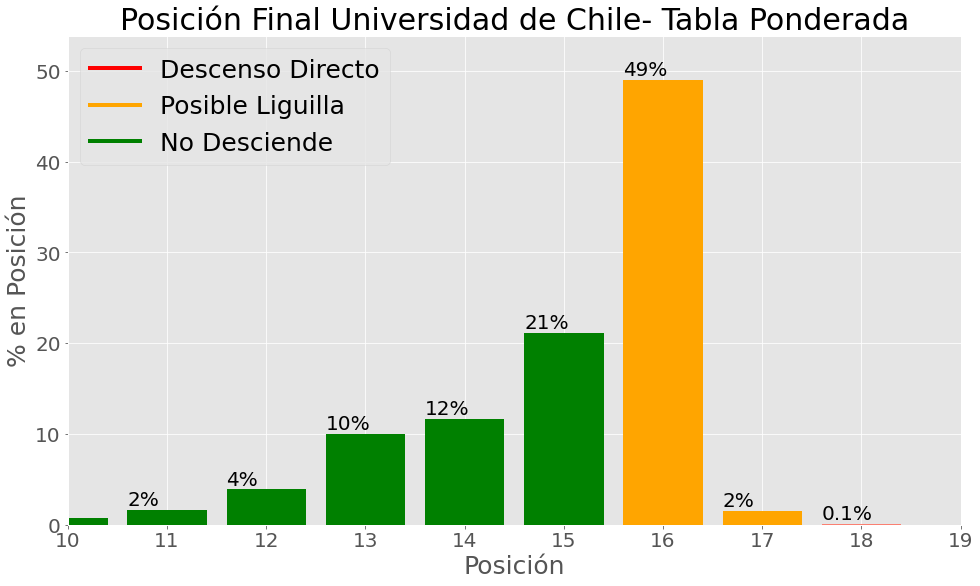

In [13]:
team = "Universidad de Chile"
probs_relegation(team, df_posicion, N_sim)

Probs Abs 0.316 0.318 0.157
Probs Pon 0.469 0.512 0.018


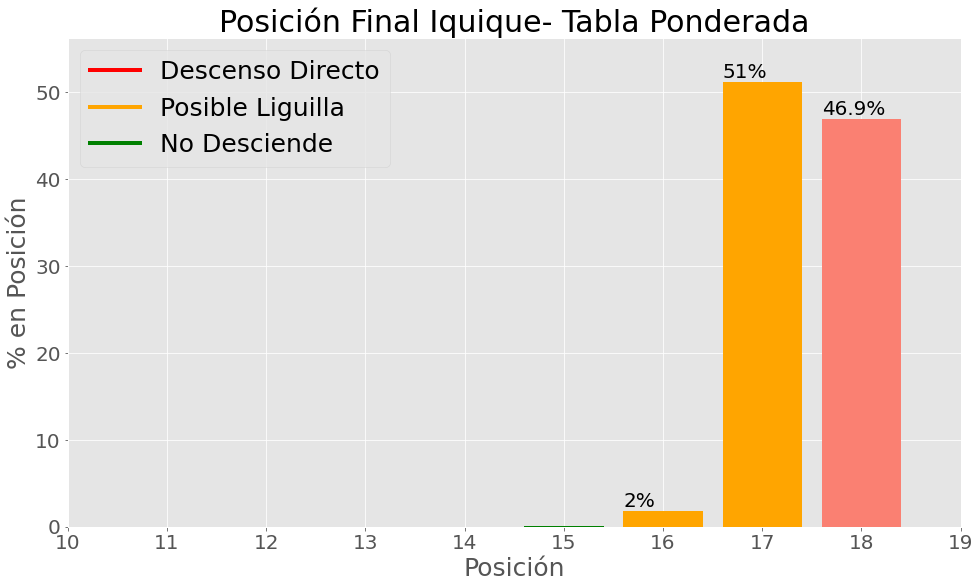

In [14]:
team = "Iquique"
probs_relegation(team, df_posicion, N_sim)

Probs Abs 0.0 0.017 0.055
Probs Pon 0.53 0.469 0.001


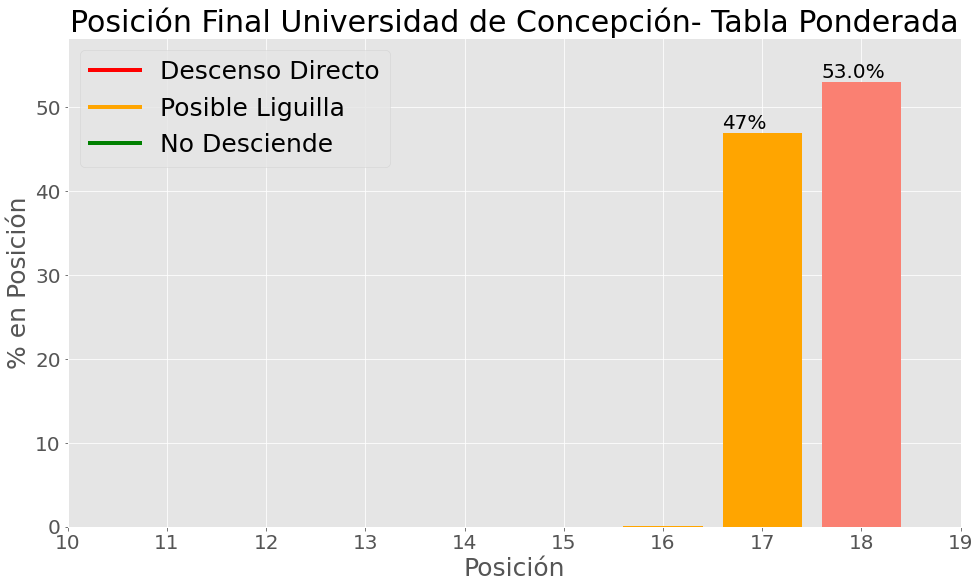

In [15]:
team = "Universidad de Concepción"
probs_relegation(team, df_posicion, N_sim)

Probs Abs 0.13 0.282 0.285
Probs Pon 0.0 0.0 0.0


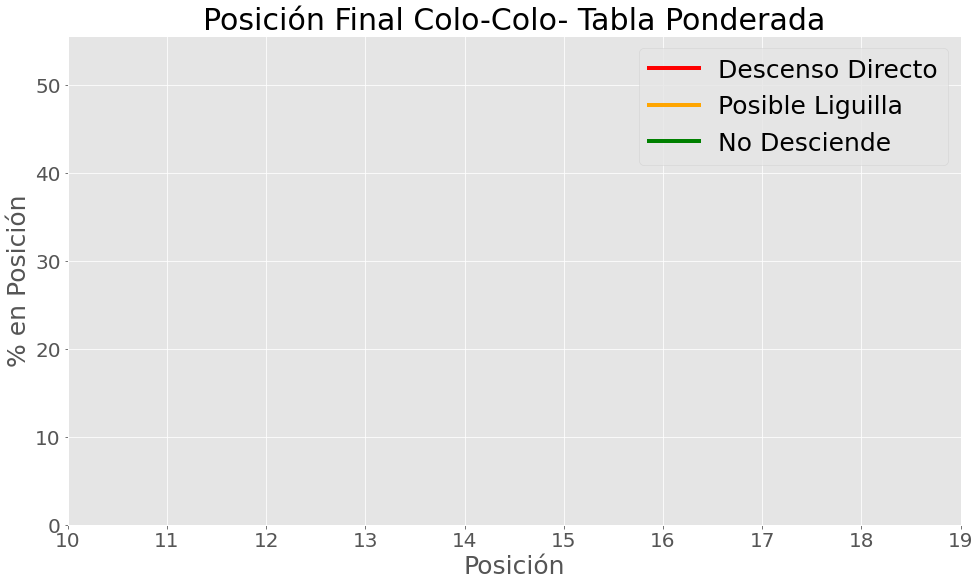

In [16]:
team = "Colo-Colo"
probs_relegation(team, df_posicion, N_sim)